# PageRank Algorithm for Web Page Ranking





PageRank ranks web pages based on their link structure. Key ideas include:

- **Random Surfer Model:** A user randomly clicking links.
- **Iterative Computation:** PageRank scores are refined iteratively until convergence.
- **Damping Factor:** Usually set to 0.85, representing the probability that a user continues clicking on links.

The PageRank formula is given by:

$$
PR(A) = (1-d) + d \left( \frac{PR(T_1)}{C(T_1)} + \frac{PR(T_2)}{C(T_2)} + \cdots + \frac{PR(T_n)}{C(T_n)} \right)
$$

Where $PR(A)$ is the PageRank of page $A$, $d$ is the damping factor, $T_i$ are pages linking to $A$, and $C(T_i)$ is the number of outbound links on page $T_i$.

## Linear Algebra Concepts in PageRank

Our implementation leverages several linear algebra techniques:
- **Adjacency Matrix:** Represents the web graph.
- **Transition Probability Matrix:** Normalizes the adjacency matrix to model link probabilities.
- **Google Matrix Formation:** Combines the transition matrix with a uniform jump matrix.
- **Eigenvalue Decomposition:** Finds the stationary distribution (the dominant eigenvector corresponding to eigenvalue 1).
- **Normalization:** Ensures that the PageRank vector sums to 1.

## Graph Construction and PageRank Computation

We construct a directed graph with a variety of connectivity patterns. Then we compute PageRank scores using:
1. **iterative_page_rank:** An iterative method with convergence tracking.
2. **eigen_page_rank:** An eigenvalue decomposition method encapsulated as a function.

Finally, we compare the two methods in terms of accuracy and computation speed.

In [1]:
# Advanced Imports and Setup
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import time

# For inline plotting in Jupyter notebooks
%matplotlib inline

# Set seed for reproducibility
np.random.seed(42)

In [2]:
# Construct an advanced directed graph with a variety of connectivity patterns
nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
edges = [
    ('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('C', 'A'),
    ('C', 'E'), ('D', 'E'), ('E', 'F'), ('F', 'D'), ('F', 'G'),
    ('G', 'H'), ('H', 'E'), ('H', 'A'), ('D', 'G'), ('B', 'F')
]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

print("Nodes:", list(G.nodes()))
print("Edges:", list(G.edges()))

Nodes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
Edges: [('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('B', 'F'), ('C', 'A'), ('C', 'E'), ('D', 'E'), ('D', 'G'), ('E', 'F'), ('F', 'D'), ('F', 'G'), ('G', 'H'), ('H', 'E'), ('H', 'A')]


In [21]:
def iterative_page_rank(G, damping=0.85, tol=1e-6, max_iter=200):
    nodes = list(G.nodes())
    n = len(nodes)

    # Adjacency matrix (row = source, col = target)
    A = nx.to_numpy_array(G, nodelist=nodes, dtype=float)

    # Out-degree (sum over rows)
    out_degree = A.sum(axis=1)

    # Transition probability matrix M (column-stochastic!)
    M = np.zeros_like(A)
    for i in range(n):  # for each source node i
        if out_degree[i] > 0:
            M[:, i] = A[i, :] / out_degree[i]
        else:
            M[:, i] = 1.0 / n  # dangling node handling

    # Initial PageRank
    pr = np.ones((n, 1)) / n
    teleport = np.ones((n, 1)) / n

    errors = []
    for it in range(max_iter):
        new_pr = damping * (M @ pr) + (1 - damping) * teleport
        error = np.linalg.norm(new_pr - pr, 1)
        errors.append(error)

        if error < tol:
            print(f"Convergence reached after {it+1} iterations with error: {error:.2e}")
            break

        pr = new_pr

    pr /= pr.sum()
    pr_dict = {nodes[i]: pr[i, 0] for i in range(n)}  # Placeholder
    return pr_dict, errors


# Compute PageRank using the iterative method
iter_pr, convergence_errors = iterative_page_rank(G, damping=0.85, tol=1e-6, max_iter=200)
print("\nIterative PageRank Scores:")
for node, score in iter_pr.items():
    print(f"Node {node}: {score:.4f}")

Convergence reached after 21 iterations with error: 8.99e-07

Iterative PageRank Scores:
Node A: 0.1146
Node B: 0.0675
Node C: 0.0866
Node D: 0.1126
Node E: 0.1625
Node F: 0.1760
Node G: 0.1414
Node H: 0.1389


In [23]:
def eigen_page_rank(G, damping=0.85):
    """
    Compute PageRank using eigenvalue decomposition of the Google matrix.

    Parameters:
      - G: networkx.DiGraph, the directed graph
      - damping: float, the damping factor

    Returns:
      - pr_dict: dict, mapping of nodes to PageRank scores
    """
    nodes = list(G.nodes())
    n = len(nodes)
    index = {node: i for i, node in enumerate(nodes)}

    # Build the adjacency matrix A
    A = nx.to_numpy_array(G, nodelist=nodes, dtype=float)

    # Compute the out-degree for each node
    out_degree = np.sum(A, axis=1)

    # Build the transition probability matrix M (column-stochastic)
    M = np.zeros_like(A)
    for i in range(n):
        if out_degree[i] > 0:
            M[:, i] = A[i, :] / out_degree[i]
        else:
            M[:, i] = 1.0 / n  # Handle dangling nodes

    # Construct the Google matrix
    G_matrix = damping * M + (1 - damping) / n * np.ones((n, n))

    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eig(G_matrix)

    # Identify the principal eigenvector (largest eigenvalue)
    eigenvalue_one_index = np.argmax(np.real(eigenvalues))
    principal_eigenvector = np.real(eigenvectors[:, eigenvalue_one_index])

    # Normalize the eigenvector
    pr = principal_eigenvector / np.sum(principal_eigenvector)

    # Map the results back to node labels
    pr_dict = {nodes[i]: pr[i] for i in range(n)}
    return pr_dict

# Compute PageRank using the eigenvalue decomposition method
eigen_pr = eigen_page_rank(G, damping=0.85)
print("\nEigenvalue Decomposition PageRank Scores:")
for node, score in eigen_pr.items():
    print(f"Node {node}: {score:.4f}")


Eigenvalue Decomposition PageRank Scores:
Node A: 0.1146
Node B: 0.0675
Node C: 0.0866
Node D: 0.1126
Node E: 0.1625
Node F: 0.1760
Node G: 0.1414
Node H: 0.1389


In [24]:
# Compare the PageRank scores obtained from the iterative method and the eigenvalue decomposition method
print("\nComparison of PageRank Scores:")
for node in G.nodes():
    # Compute the absolute difference between the two PageRank scores
    diff = abs(iter_pr[node] - eigen_pr[node])
    print(f"Node {node}: Iterative = {iter_pr[node]:.4f}, Eigen = {eigen_pr[node]:.4f}, Difference = {diff:.2e}")


Comparison of PageRank Scores:
Node A: Iterative = 0.1146, Eigen = 0.1146, Difference = 8.18e-08
Node B: Iterative = 0.0675, Eigen = 0.0675, Difference = 1.38e-07
Node C: Iterative = 0.0866, Eigen = 0.0866, Difference = 1.20e-07
Node D: Iterative = 0.1126, Eigen = 0.1126, Difference = 4.71e-08
Node E: Iterative = 0.1625, Eigen = 0.1625, Difference = 1.29e-07
Node F: Iterative = 0.1760, Eigen = 0.1760, Difference = 9.07e-08
Node G: Iterative = 0.1414, Eigen = 0.1414, Difference = 1.73e-08
Node H: Iterative = 0.1389, Eigen = 0.1389, Difference = 2.02e-07


In [30]:
# Compare the execution speed of the iterative and eigenvalue decomposition methods
start_iter = time.time()
iter_pr, convergence_errors = iterative_page_rank(G, damping=0.85, tol=1e-6, max_iter=200)
iter_time = time.time() - start_iter

start_eigen = time.time()
eigen_pr = eigen_page_rank(G, damping=0.85)
eigen_time = time.time() - start_eigen

print("Execution Time Comparison:")
print(f"Iterative method time: {iter_time:.6f} seconds")
print(f"Eigenvalue method time: {eigen_time:.6f} seconds")


Convergence reached after 21 iterations with error: 8.99e-07
Execution Time Comparison:
Iterative method time: 0.001364 seconds
Eigenvalue method time: 0.000856 seconds


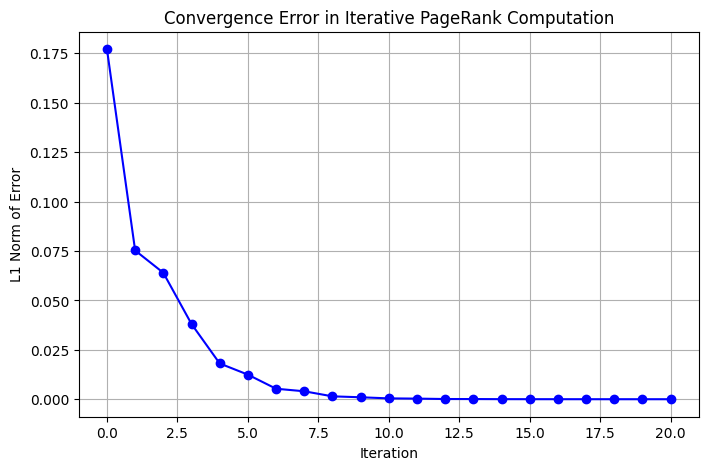

In [31]:
# Plot the convergence error over iterations from the iterative method
plt.figure(figsize=(8, 5))
plt.plot(convergence_errors, marker='o', linestyle='-', color='b')
plt.title("Convergence Error in Iterative PageRank Computation")
plt.xlabel("Iteration")
plt.ylabel("L1 Norm of Error")
plt.grid(True)
plt.show()

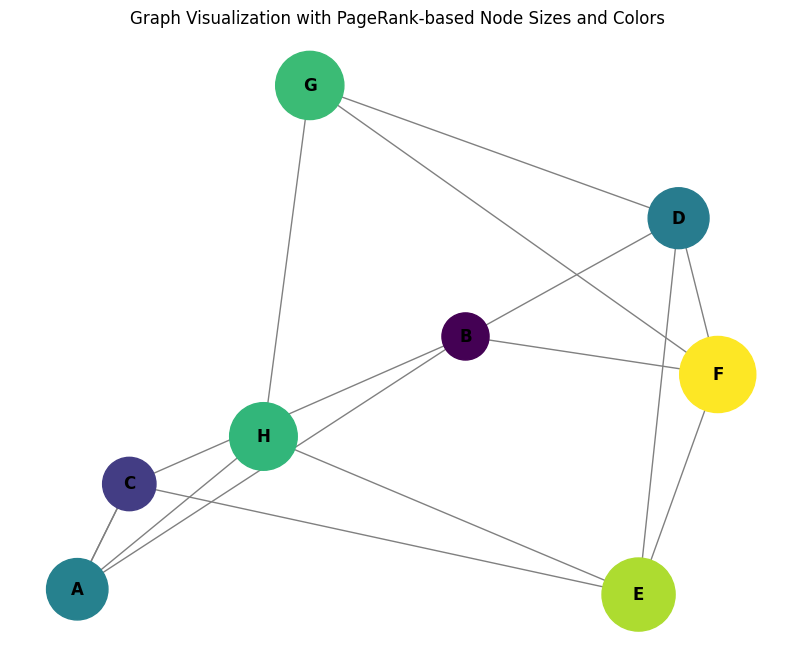

In [32]:
# Visualize the graph with nodes sized and colored based on the eigenvalue-based PageRank scores

# Compute layout for nodes
pos = nx.spring_layout(G, seed=42)

# Scale node sizes based on eigenvalue PageRank scores
pagerank_values = np.array(list(eigen_pr.values()))
node_sizes = 3000 * (pagerank_values / pagerank_values.max())

# Map PageRank values to colors using a colormap
norm = plt.Normalize(vmin=pagerank_values.min(), vmax=pagerank_values.max())
node_colors = cm.viridis(norm(pagerank_values))

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title("Graph Visualization with PageRank-based Node Sizes and Colors")
plt.axis('off')
plt.show()